# Import Packages

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os , pickle
# Modeling
from sklearn.linear_model import LinearRegression , Lasso , Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor 
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

### Import CSV File as Pandas DataFrame

In [7]:
df = pd.read_csv('../data/StudentsPerformance.csv')

### Show Top 5 records

In [8]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Define Features

In [9]:
num_feature = ["reading score", "writing score"]
cat_features = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
]

## Train-Test Split

In [10]:
X = df.drop("math score" , axis=1)
y = df["math score"]

X_train , X_test , y_train , y_test = train_test_split(
     X , y , random_state=42
)

### Encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

# categorical columns
cat_features = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
]

encoder = OneHotEncoder(drop="first", handle_unknown="ignore")

X_train_cat = encoder.fit_transform(X_train[cat_features]).toarray()
X_test_cat = encoder.transform(X_test[cat_features]).toarray()

# create new column names
cat_new_cols = encoder.get_feature_names_out(cat_features)

# make DataFrames
X_train_cat = pd.DataFrame(X_train_cat, columns=cat_new_cols, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=cat_new_cols, index=X_test.index)

# drop original categorical and join encoded
X_train = X_train.drop(cat_features, axis=1).join(X_train_cat)
X_test = X_test.drop(cat_features, axis=1).join(X_test_cat)


## Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

num_feature = ["reading score", "writing score"]

scaler = StandardScaler()

X_train[num_feature] = scaler.fit_transform(X_train[num_feature])
X_test[num_feature] = scaler.transform(X_test[num_feature])


## Model Selection

In [13]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0),
    "AdaBoostRegressor": AdaBoostRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(f"\n{name}")
    print(f"Training Set -> RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
    print(f"Test Set     -> RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
    print("="*50)
    
    # Save results
    results.append({
        "Model": name,
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    })

# Summary
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="Test R2", ascending=False)
print("\nSummary of All Models (sorted by Test R2):")
print(results_df_sorted)


LinearRegression
Training Set -> RMSE: 5.2972, MAE: 4.2383, R2: 0.8743
Test Set     -> RMSE: 5.4825, MAE: 4.3379, R2: 0.8778

Lasso
Training Set -> RMSE: 6.5469, MAE: 5.1796, R2: 0.8080
Test Set     -> RMSE: 6.6500, MAE: 5.2184, R2: 0.8202

Ridge
Training Set -> RMSE: 5.2977, MAE: 4.2371, R2: 0.8743
Test Set     -> RMSE: 5.4814, MAE: 4.3365, R2: 0.8779

K-Neighbors Regressor
Training Set -> RMSE: 5.6662, MAE: 4.5136, R2: 0.8562
Test Set     -> RMSE: 7.1851, MAE: 5.5632, R2: 0.7902

Decision Tree
Training Set -> RMSE: 0.2887, MAE: 0.0200, R2: 0.9996
Test Set     -> RMSE: 7.8442, MAE: 6.1240, R2: 0.7499

Random Forest Regressor
Training Set -> RMSE: 2.2808, MAE: 1.8248, R2: 0.9767
Test Set     -> RMSE: 6.1594, MAE: 4.8441, R2: 0.8458

XGBRegressor
Training Set -> RMSE: 0.9169, MAE: 0.6051, R2: 0.9962
Test Set     -> RMSE: 6.3952, MAE: 5.0380, R2: 0.8338

CatBoostRegressor
Training Set -> RMSE: 2.9935, MAE: 2.3475, R2: 0.9599
Test Set     -> RMSE: 5.9997, MAE: 4.6608, R2: 0.8537

AdaBoos

In [14]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Test R2", ascending=False)


,Model,Train RMSE,Train MAE,Train R2,Test RMSE,Test MAE,Test R2
2,Ridge,5.297718,4.237113,0.874251,5.481414,4.336520,0.877874
0,LinearRegression,5.297245,4.238267,0.874273,5.482528,4.337931,0.877824
7,CatBoostRegressor,2.993462,2.347517,0.959851,5.999681,4.660790,0.853688
8,AdaBoostRegressor,5.809975,4.735149,0.848757,6.148549,4.813059,0.846337
5,Random Forest Regressor,2.280839,1.824787,0.976691,6.159359,4.844079,0.845797
6,XGBRegressor,0.916942,0.605088,0.996233,6.395175,5.038007,0.833763
1,Lasso,6.546937,5.179565,0.807955,6.650049,5.218406,0.820248
3,K-Neighbors Regressor,5.666180,4.513600,0.856150,7.185073,5.563200,0.790161
4,Decision Tree,0.288675,0.020000,0.999627,7.844234,6.124000,0.749894


### Model Selection

In [15]:
pd.DataFrame(results)[["Model", "Test R2"]].sort_values(by="Test R2", ascending=False)


,Model,Test R2
2,Ridge,0.877874
0,LinearRegression,0.877824
7,CatBoostRegressor,0.853688
8,AdaBoostRegressor,0.846337
5,Random Forest Regressor,0.845797
6,XGBRegressor,0.833763
1,Lasso,0.820248
3,K-Neighbors Regressor,0.790161
4,Decision Tree,0.749894


## Linear Regression

In [16]:
best_model = LinearRegression()
best_model.fit(X_train, y_train)

y_train_best = best_model.predict(X_train)
y_test_best = best_model.predict(X_test)

train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_best)
test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_best)

print("\n✅ Final Model: Linear Regression")
print(f"Training Set -> RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
print(f"Test Set     -> RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")


✅ Final Model: Linear Regression
Training Set -> RMSE: 5.2972, MAE: 4.2383, R2: 0.8743
Test Set     -> RMSE: 5.4825, MAE: 4.3379, R2: 0.8778


### Plot y_pred and y_test

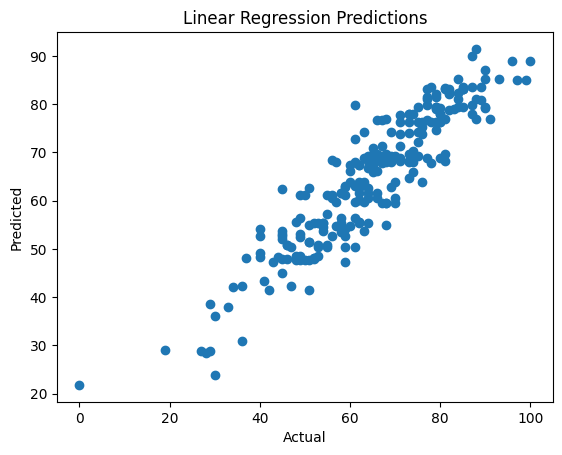

In [18]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Predictions')
plt.show()

<Axes: xlabel='math score'>

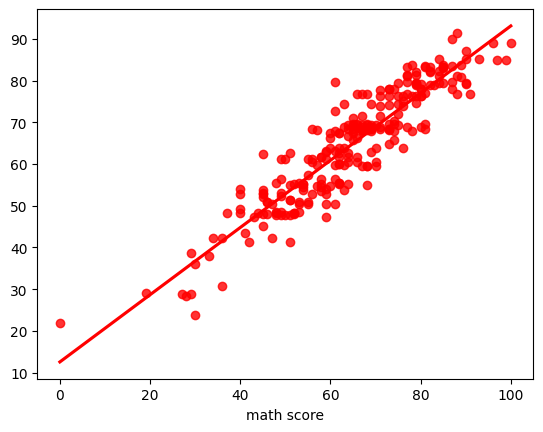

In [19]:
sns.regplot(x=y_test , y=y_test_pred , ci=None , color='red')

### Difference between Actual and Predicted Values

In [20]:
pred_df = pd.DataFrame({'Actual Value': y_test , 'Predicted Value': y_test_pred , 'Difference': y_test-y_test_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.896552,14.103448
737,53,55.467290,-2.467290
740,80,77.928177,2.071823
660,74,77.928177,-3.928177
411,84,82.277311,1.722689
...,...,...,...
109,70,60.554404,9.445596
430,64,62.632911,1.367089
77,80,79.225352,0.774648
84,42,41.380952,0.619048


## Save Model

In [21]:
import os
import pickle

models_path = r"c:\\Users\\admin\\OneDrive\\Documents\\GitHub\\student-performance-indicator-ml-project\\models"

os.makedirs(models_path, exist_ok=True)

with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("onehot_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and preprocessing objects saved successfully!")


✅ Model and preprocessing objects saved successfully!
